In [1]:
import numpy as np 
import pandas as pd 
import math 
import glob
import os
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
# import wandb 

import folium
from geopy.geocoders import Nominatim
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

## Input and revue data


In [2]:
products_link = '/kaggle/input/learnplatform-covid19-impact-on-digital-learning/products_info.csv'
read_link = '/kaggle/input/learnplatform-covid19-impact-on-digital-learning/README.md'
districts_link = '/kaggle/input/learnplatform-covid19-impact-on-digital-learning/districts_info.csv'
dir_link = '/kaggle/input/learnplatform-covid19-impact-on-digital-learning/engagement_data/'

**We upload data about products and districts, we understand the columns.**

### Products data
| Name                       | Description                                                                                                                                                                                                                                                                                                                    |
|----------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **LP ID**                      | The unique identifier of the product                                                                                                                                                                                                                                                                                           |
| **URL**                        | Web Link to the specific product                                                                                                                                                                                                                                                                                               |
| **Product Name**               | Name of the specific product                                                                                                                                                                                                                                                                                                   |
| **Provider/Company Name**      | Name of the product provider                                                                                                                                                                                                                                                                                                   |
| **Sector(s)**                  | Sector of education where the product is used                                                                                                                                                                                                                                                                                  |
| **Primary Essential Function** | The basic function of the product. There are two layers of labels here. Products are first labeled as one of these three categories: LC = Learning & Curriculum, CM = Classroom Management, and SDO = School & District Operations. Each of these categories have multiple sub-categories with which the products were labeled |
|                            |            

In [3]:
data_products = pd.read_csv(products_link)
data_districts = pd.read_csv(districts_link)
data_products.head().style.set_caption('Product data')

,LP ID,URL,Product Name,Provider/Company Name,Sector(s),Primary Essential Function
0,13117,https://www.splashmath.com,SplashLearn,StudyPad Inc.,PreK-12,LC - Digital Learning Platforms
1,66933,https://abcmouse.com,ABCmouse.com,"Age of Learning, Inc",PreK-12,LC - Digital Learning Platforms
2,50479,https://www.abcya.com,ABCya!,"ABCya.com, LLC",PreK-12,"LC - Sites, Resources & Reference - Games & Simulations"
3,92993,http://www.aleks.com/,ALEKS,McGraw-Hill PreK-12,PreK-12; Higher Ed,LC - Digital Learning Platforms
4,73104,https://www.achieve3000.com/,Achieve3000,Achieve3000,PreK-12,LC - Digital Learning Platforms


### Districts data
| Name                   | Description                                                                                                                                                                                                                                                                              |
|------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **district_id**            | The unique identifier of the school district                                                                                                                                                                                                                                             |
| **state**                  | The state where the district resides in                                                                                                                                                                                                                                                  |
| **locale**                 | NCES locale classification that categorizes U.S. territory into four types of areas: City, Suburban, Town, and Rural. See Locale Boundaries User's Manual for more information.                                                                                                          |
| **pct_black/hispanic**     | Percentage of students in the districts identified as Black or Hispanic based on 2018-19 NCES data                                                                                                                                                                                       |
| **pct_free/reduced**       | Percentage of students in the districts eligible for free or reduced-price lunch based on 2018-19 NCES data                                                                                                                                                                              |
| **county_connections_ratio** | ratio (residential fixed high-speed connections over 200 kbps in at least one direction/households) based on the county level data from FCC From 477 (December 2018 version). See FCC data for more information.                                                                         |
| **pp_total_raw**             | Per-pupil total expenditure (sum of local and federal expenditure) from Edunomics Lab's National Education Resource Database on Schools (NERD$) project. The expenditure data are school-by-school, and we use the median value to represent the expenditure of a given school district. |

In [4]:
data_districts.head().style.set_caption('District data')

,district_id,state,locale,pct_black/hispanic,pct_free/reduced,county_connections_ratio,pp_total_raw
0,8815,Illinois,Suburb,"[0, 0.2[","[0, 0.2[","[0.18, 1[","[14000, 16000["
1,2685,nan,nan,nan,nan,nan,nan
2,4921,Utah,Suburb,"[0, 0.2[","[0.2, 0.4[","[0.18, 1[","[6000, 8000["
3,3188,nan,nan,nan,nan,nan,nan
4,2238,nan,nan,nan,nan,nan,nan


**We collect data each district in one table "Engagement data"**
### Engagement data

| Name             | Description                                                                                                    |
|------------------|----------------------------------------------------------------------------------------------------------------|
| **time**             | date in "YYYY-MM-DD"                                                                                           |
| **lp_id**            | The unique identifier of the product                                                                           |
| **pct_access**       | Percentage of students in the district have at least one page-load event of a given product and on a given day |
| **engagement_index** | Total page-load events per one thousand students of a given product and on a given day                         |
| **district_id**            | The unique identifier of the school district  

In [5]:
all_files = glob.glob(dir_link + "*.csv")

list_df = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    district_id = filename.split("/")[5].split(".")[0]
    df["district_id"] = district_id
    list_df.append(df)
    
data_engagement = pd.concat(list_df)
data_engagement = data_engagement.reset_index(drop=True)
data_engagement.head().style.set_caption('Engagement data')

,time,lp_id,pct_access,engagement_index,district_id
0,2020-01-01,92844.000000,0.010000,0.680000,6345
1,2020-01-01,64838.000000,0.010000,0.680000,6345
2,2020-01-01,94058.000000,0.000000,nan,6345
3,2020-01-01,26488.000000,0.030000,26.210000,6345
4,2020-01-01,32340.000000,0.010000,0.110000,6345


**Let's look at the number of omissions in the tables**

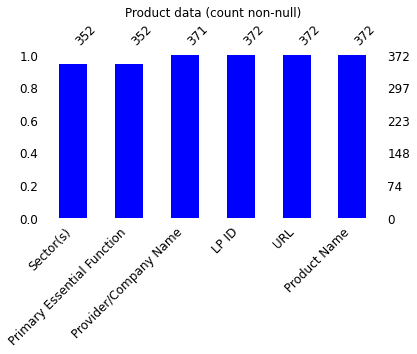

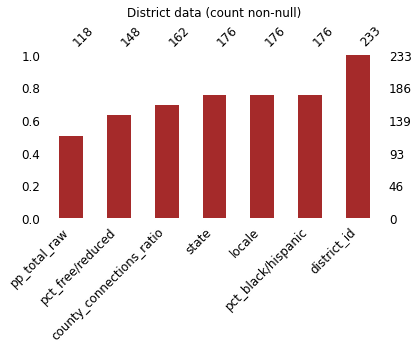

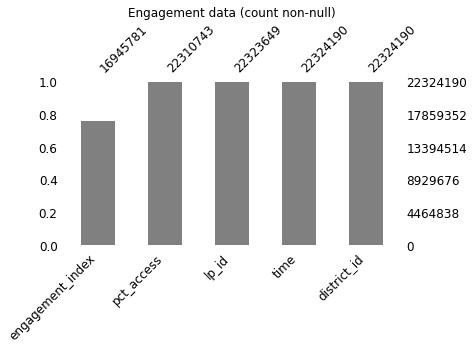

In [6]:
msno.bar(data_products,color='blue', sort="ascending", figsize=(6,3), fontsize=12)
plt.title('Product data (count non-null)')
plt.show()
msno.bar(data_districts,color='brown', sort="ascending", figsize=(6,3), fontsize=12)
plt.title('District data (count non-null)')
plt.show()
msno.bar(data_engagement,color='grey', sort="ascending", figsize=(6,3), fontsize=12)
plt.title('Engagement data (count non-null)')
plt.show()

**We monitor the number of unique elements in each table.**

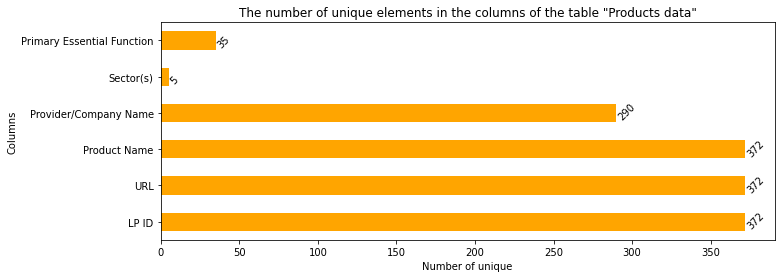

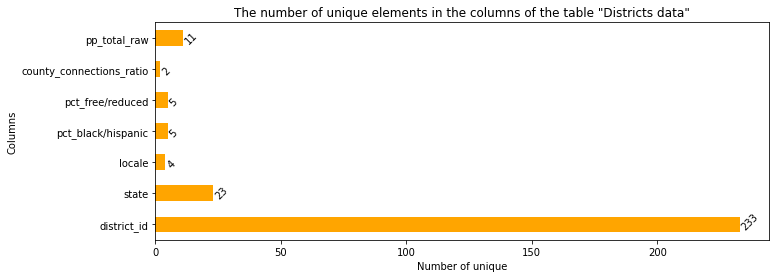

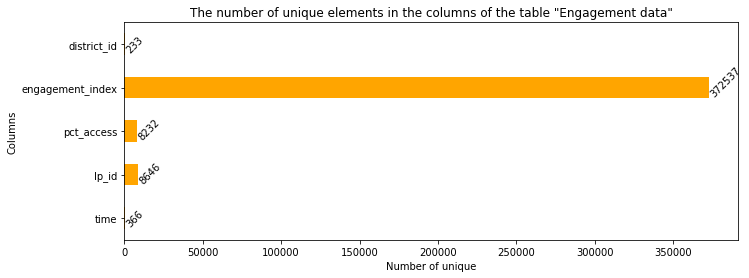

In [7]:
def get_hist_unique(table, text):
    buf = table.nunique()
    ax = buf.plot(kind='barh', color='orange', figsize=(11,4))
    
    ax.set_title("The number of unique elements in the columns of the table " + text)
    ax.set_xlabel("Number of unique")
    ax.set_ylabel("Columns")
    
    rects = ax.patches
    
    for rect, label in zip(rects, buf.values):
        width = rect.get_width()
        ax.text(
            width, rect.get_y(), label, ha="left", va="bottom", rotation=45
        )
    plt.show()
    
    
get_hist_unique(data_products, '\"Products data\"')
get_hist_unique(data_districts, '\"Districts data\"')
get_hist_unique(data_engagement, '\"Engagement data\"')

**We split the feature "Primary Essential Function" on two part**

In [8]:
primary_essential_main = []
primary_essential_sub = []
for s in data_products["Primary Essential Function"]:
    if(not pd.isnull(s)):
        s1 = s.split("-",1)[0].strip()
        primary_essential_main.append(s1)
    else:
        primary_essential_main.append(np.nan)
    
    if(not pd.isnull(s)):
        s2 = s.split("-",1)[1].strip()
        primary_essential_sub.append(s2)
    else:
        primary_essential_sub.append(np.nan)

data_products["Primary_essential_main"] = primary_essential_main
data_products["Primary_essential_sub"] = primary_essential_sub

**We change " NaN " on "No data" to track their number on the charts.**

In [9]:
changed_nan_data_districts = data_districts[['state', 'locale', 'pct_black/hispanic',
    'pct_free/reduced', 'county_connections_ratio', 'pp_total_raw']].fillna("No data")
changed_nan_data_products =data_products[['URL', 'Product Name', 'Provider/Company Name', 
   'Sector(s)', 'Primary_essential_main', 'Primary_essential_sub']].fillna("No data")
changed_nan_data_engagement = data_engagement[['engagement_index','lp_id', 'pct_access', 
                 'engagement_index']].fillna("No data")

## Detailed overview of products

In [10]:
data_products.head().style.set_caption('Products data')

,LP ID,URL,Product Name,Provider/Company Name,Sector(s),Primary Essential Function,Primary_essential_main,Primary_essential_sub
0,13117,https://www.splashmath.com,SplashLearn,StudyPad Inc.,PreK-12,LC - Digital Learning Platforms,LC,Digital Learning Platforms
1,66933,https://abcmouse.com,ABCmouse.com,"Age of Learning, Inc",PreK-12,LC - Digital Learning Platforms,LC,Digital Learning Platforms
2,50479,https://www.abcya.com,ABCya!,"ABCya.com, LLC",PreK-12,"LC - Sites, Resources & Reference - Games & Simulations",LC,"Sites, Resources & Reference - Games & Simulations"
3,92993,http://www.aleks.com/,ALEKS,McGraw-Hill PreK-12,PreK-12; Higher Ed,LC - Digital Learning Platforms,LC,Digital Learning Platforms
4,73104,https://www.achieve3000.com/,Achieve3000,Achieve3000,PreK-12,LC - Digital Learning Platforms,LC,Digital Learning Platforms


**Let's estimate the precedence of each category in categorical features in the table "Products data", taking into account the missing values.**

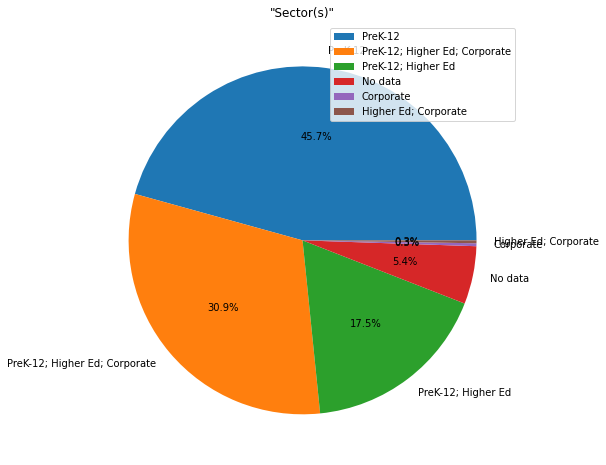

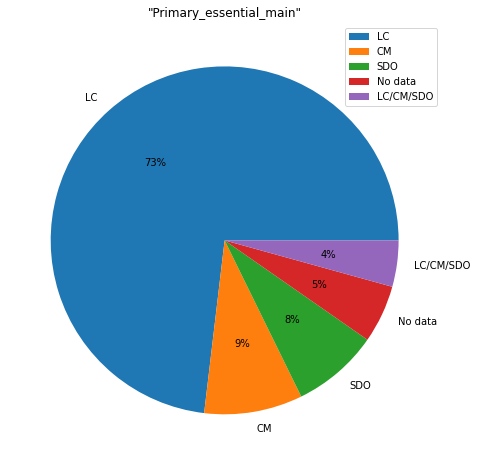

In [11]:
def make_pie(data, column, figsize, form):
    data[column].value_counts().plot(
        kind = 'pie', autopct=form, figsize=figsize,
        startangle=0, label='',title='\"'+column+'\"').legend();
    plt.show()

make_pie(changed_nan_data_products, "Sector(s)", (8,8), '%1.1f%%')
make_pie(changed_nan_data_products, "Primary_essential_main", (8,8), '%1.f%%')

**Let 's compare the most numerous signs.**

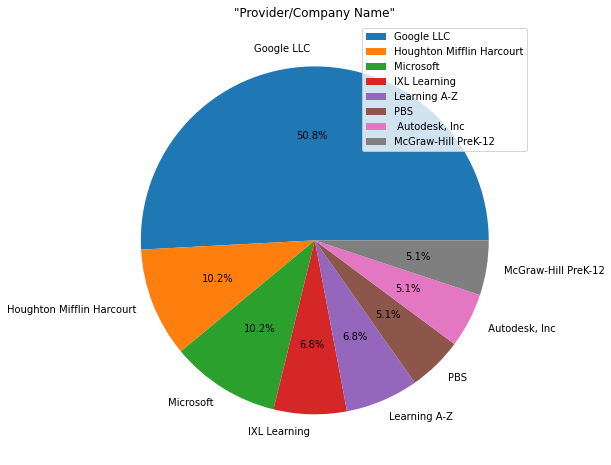

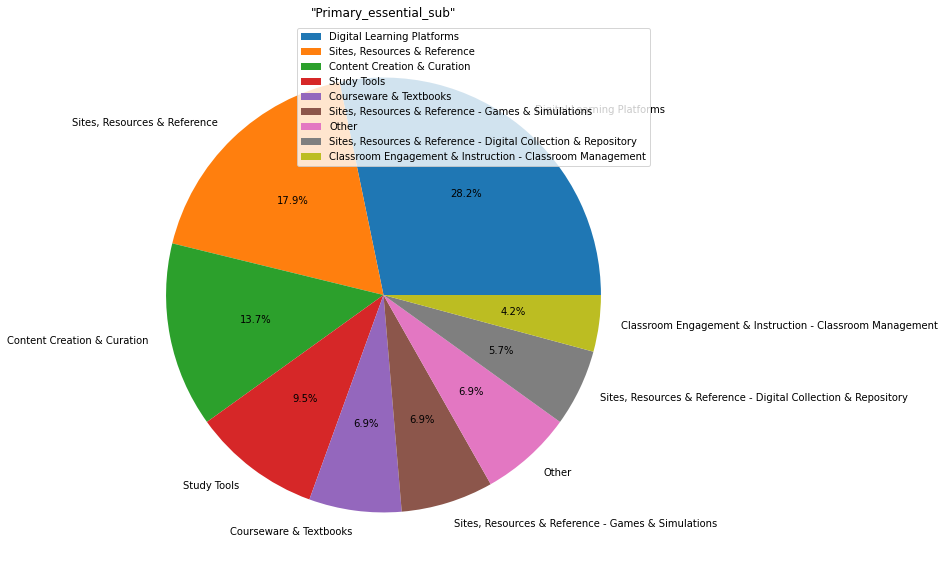

In [12]:
def make_part_pie(data, column, pct, figsize, form):
    buf = data[column].value_counts()
    buf[:int(buf.shape[0] * pct)].plot(kind = 'pie', autopct=form, figsize=figsize,
                                       startangle=0, label='',title='\"'+column+'\"').legend();
    plt.show()
    
make_part_pie(data_products, 'Provider/Company Name', 0.03, (15,8), '%1.1f%%')
make_part_pie(data_products, 'Primary_essential_sub', 0.28, (15,10), '%1.1f%%')

## Detailed overview of districts

In [13]:
data_districts.head().style.set_caption('District data')

,district_id,state,locale,pct_black/hispanic,pct_free/reduced,county_connections_ratio,pp_total_raw
0,8815,Illinois,Suburb,"[0, 0.2[","[0, 0.2[","[0.18, 1[","[14000, 16000["
1,2685,nan,nan,nan,nan,nan,nan
2,4921,Utah,Suburb,"[0, 0.2[","[0.2, 0.4[","[0.18, 1[","[6000, 8000["
3,3188,nan,nan,nan,nan,nan,nan
4,2238,nan,nan,nan,nan,nan,nan


**Let's estimate the precedence of each category in categorical features in the table "Distrincts data", taking into account the missing values.**

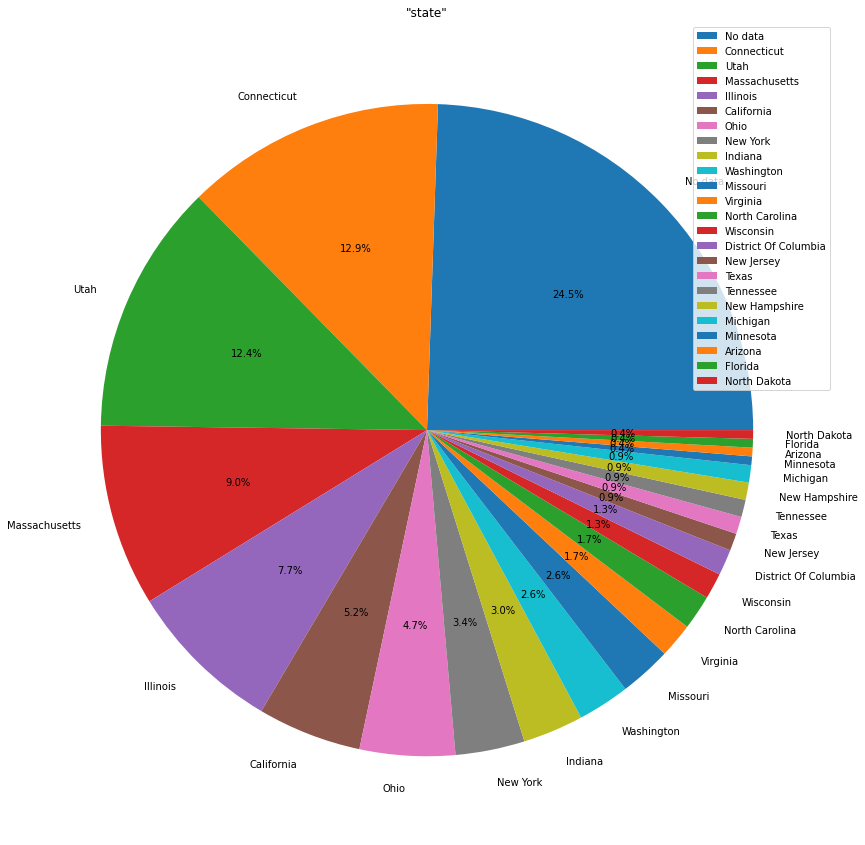

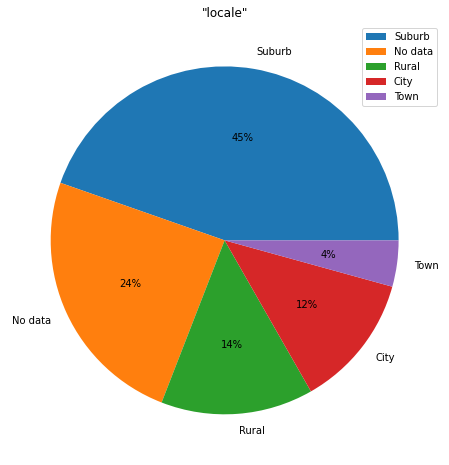

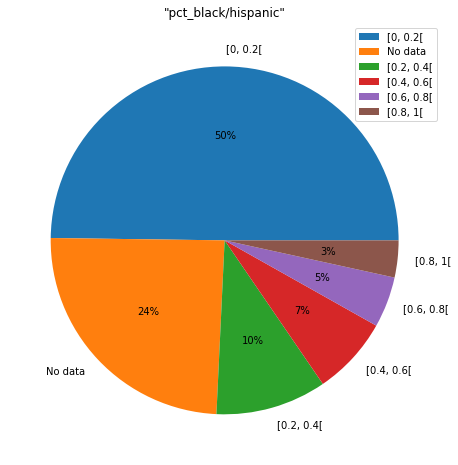

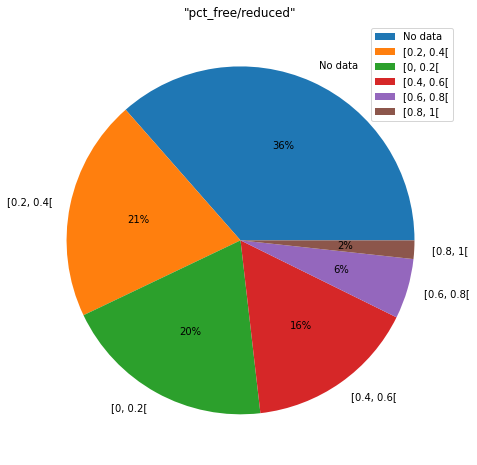

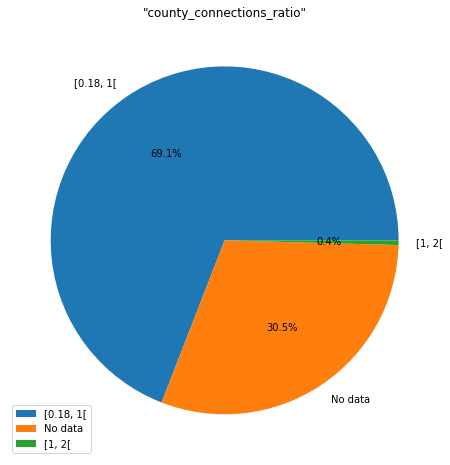

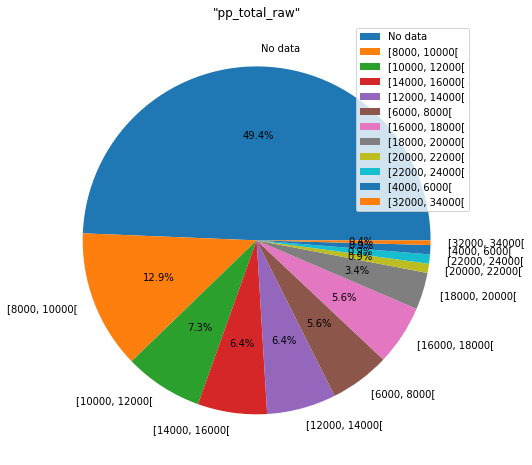

In [14]:
make_pie(changed_nan_data_districts, "state", (15,15), '%1.1f%%')
make_pie(changed_nan_data_districts, "locale", (8,8), '%1.f%%')
make_pie(changed_nan_data_districts, "pct_black/hispanic", (8,8), '%1.f%%')
make_pie(changed_nan_data_districts, "pct_free/reduced", (8,8), '%1.f%%')
make_pie(changed_nan_data_districts, "county_connections_ratio", (8,8), '%1.1f%%') 
make_pie(changed_nan_data_districts, "pp_total_raw", (8,8), '%1.1f%%') 

**We can see that the percentage of missing persons makes up most of the charts.**
**We can calculate the percentage of occupancy of each row and look at it.**

In [15]:
data_districts['pct_missing'] = round(data_districts.isna().sum(axis=1) / 7.0, 2)
data_districts

,district_id,state,locale,pct_black/hispanic,pct_free/reduced,county_connections_ratio,pp_total_raw,pct_missing
0,8815,Illinois,Suburb,"[0, 0.2[","[0, 0.2[","[0.18, 1[","[14000, 16000[",0.00
1,2685,NaN,NaN,NaN,NaN,NaN,NaN,0.86
2,4921,Utah,Suburb,"[0, 0.2[","[0.2, 0.4[","[0.18, 1[","[6000, 8000[",0.00
3,3188,NaN,NaN,NaN,NaN,NaN,NaN,0.86
4,2238,NaN,NaN,NaN,NaN,NaN,NaN,0.86
...,...,...,...,...,...,...,...,...
228,9515,New York,Rural,"[0, 0.2[","[0.4, 0.6[","[0.18, 1[","[18000, 20000[",0.00
229,8103,Tennessee,Rural,"[0.2, 0.4[",NaN,"[0.18, 1[","[8000, 10000[",0.14
230,4929,Virginia,Rural,"[0, 0.2[","[0.4, 0.6[","[0.18, 1[","[12000, 14000[",0.00
231,7975,California,City,"[0.6, 0.8[","[0.6, 0.8[","[0.18, 1[",NaN,0.14


**Let's look at the number of rows with each percent of occupancy.**
**We see that in 57 (out of 233) lines only "district_id" is filled in.**

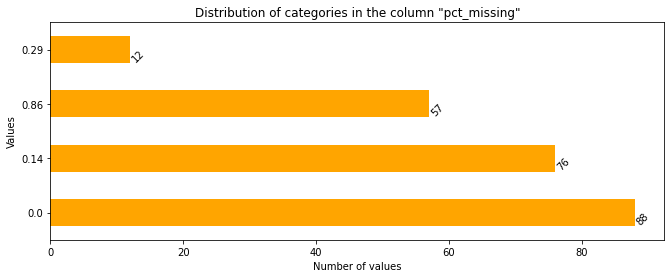

In [16]:
def get_hist_column(column, text):
    ax = column.plot(kind='barh', color='orange', figsize=(11,4))
    
    ax.set_title("Distribution of categories in the column " + text)
    ax.set_xlabel("Number of values")
    ax.set_ylabel("Values")
    
    rects = ax.patches
    
    for rect, label in zip(rects, column.values):
        width = rect.get_width()
        ax.text(
            width, rect.get_y(), label, ha="left", va="bottom", rotation=45
        )
    plt.show()


get_hist_column(data_districts['pct_missing'].value_counts(), '\"pct_missing\"')

**Let's select all the row IDs with the highest percentage of occupancy.**

In [17]:
districts_with_zero_data = data_districts.loc[data_districts.pct_missing == 0.86, 'district_id'].values
print("\"district_id\" rows with empty description: ", districts_with_zero_data)
data_engagement.district_id = data_engagement.district_id.astype('int32')
print("The number of interactions from areas about which there is no information: ", 
    data_engagement.loc[data_engagement.district_id.isin(districts_with_zero_data), 'engagement_index'].shape[0])
print("The number of interactions about which there is no information, from areas about which there is no information: ",
    data_engagement.loc[data_engagement.district_id.isin(districts_with_zero_data), 'engagement_index'].isnull().sum())

"district_id" rows with empty description:  [2685 3188 2238 8515 2339 9120 4666 1131 4591 3393 3580 8685 1179 8184
 4029 5257 5903 6165 7858 5380 2017 9839 7352 4749 2549 3371 1584 3471
 3959 4203 7086 7829 6049 4408 6721 9729 5970 8017 4937 1039 6665 5057
 2209 8796 3301 8723 6066 6131 1624 8160 8702 8845 4165 6774 3390 5404
 9463]
The number of interactions from areas about which there is no information:  4888446
The number of interactions about which there is no information, from areas about which there is no information:  1081062


**We see that there is engagement information from the district with an empty description. Therefore, we will remove the gaps depending on the task.**

## Detailed overview of engagement

**We will also add a column with the percentage of skips of each engagement.**

In [18]:
data_engagement['pct_missing'] = round(data_engagement.isna().sum(axis=1) / 5., 2)
data_engagement.head().style.set_caption('Engagement data')

,time,lp_id,pct_access,engagement_index,district_id,pct_missing
0,2020-01-01,92844.000000,0.010000,0.680000,6345,0.000000
1,2020-01-01,64838.000000,0.010000,0.680000,6345,0.000000
2,2020-01-01,94058.000000,0.000000,nan,6345,0.200000
3,2020-01-01,26488.000000,0.030000,26.210000,6345,0.000000
4,2020-01-01,32340.000000,0.010000,0.110000,6345,0.000000


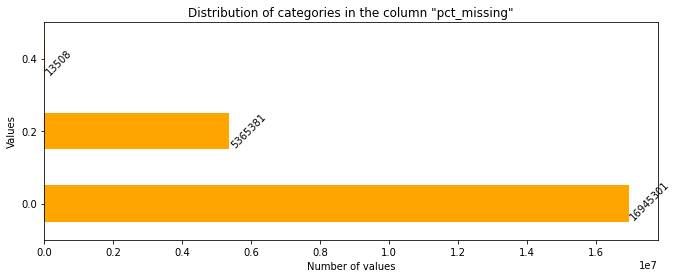

In [19]:
get_hist_column(data_engagement['pct_missing'].value_counts(), '\"pct_missing\"')

In [20]:
print("Count omissions in column \"engagement_index\": ",
    data_engagement.engagement_index.isna().sum())
print("Count omissions in column \"time\": ",
    data_engagement.time.isna().sum())

Count omissions in column "engagement_index":  5378409
Count omissions in column "time":  0


### Answers to questions

#### What is the picture of digital connectivity and engagement in 2020?

**The question is broad. The main answer will be a time representation of the number of sessions.**

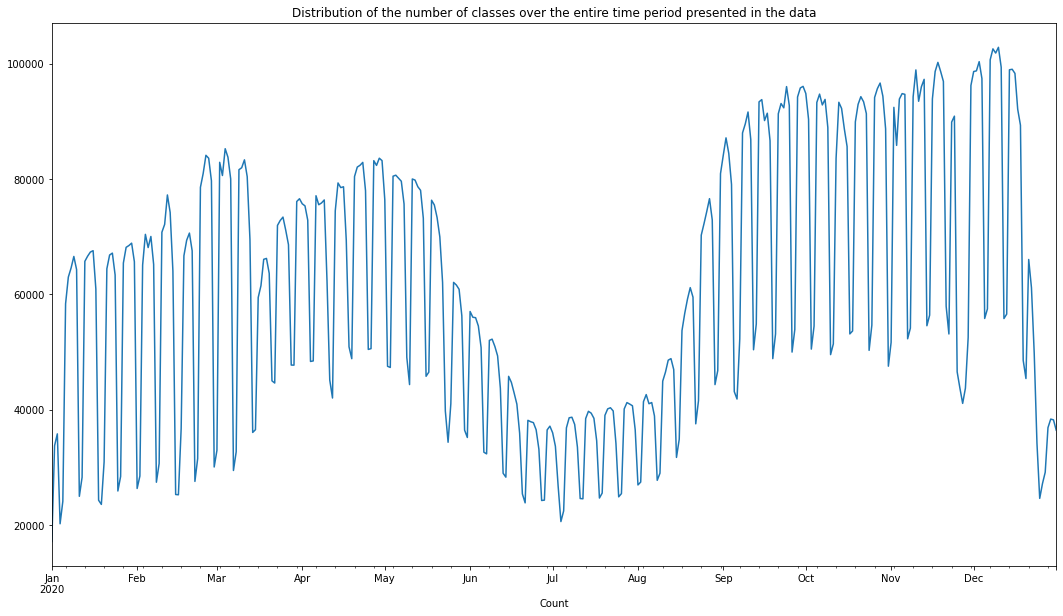

In [21]:
data_engagement.time = data_engagement.time.astype('datetime64')
data_engagement.time.value_counts(sort=False).plot(figsize=(18,10)).set_title("Distribution of the number of classes over the entire time period presented in the data");
plt.xlabel('Date');
plt.xlabel('Count');

**In general, there is a tendency to increase the number of online events held by the end of the year.**

#### What is the effect of the COVID-19 pandemic on online and distance learning, and how might this also evolve in the future?
**The impact of the pandemic has primarily on the number of distance learning - it is growing. In the future, it is worth developing the quality of distance education, the start of which occurred at the beginning of the pandemic.**


#### How does student engagement with online learning platforms relate to different geography?

**Let's collect the coordinates of the states.**

In [22]:
from geopy.geocoders import Nominatim
locations=pd.DataFrame({"Name": data_districts['state'].unique()})

geolocator=Nominatim(user_agent="app")
lat=[]
lon=[]
for location in locations['Name']:
    location = geolocator.geocode(location)    
    if location is None:
        lat.append(np.nan)
        lon.append(np.nan)
    else:
        lat.append(location.latitude)
        lon.append(location.longitude)
        
locations['lat']=lat
locations['lon']=lon

map_locations=pd.DataFrame(data_districts['state'].value_counts().reset_index())
map_locations.columns = ['Name', 'Count']
map_locations
final_loc = map_locations.merge(locations,on='Name',how="left").dropna()
final_loc.head(5).style.set_caption("Locations states")

,Name,Count,lat,lon
0,Connecticut,30,41.650020,-72.734216
1,Utah,29,39.422519,-111.714358
2,Massachusetts,21,42.378877,-72.032366
3,Illinois,18,40.079661,-89.433729
4,California,12,36.701463,-118.755997


**Let's display districts on the map. Color indicate their density.**

In [23]:
from folium.plugins import HeatMap, MarkerCluster, FastMarkerCluster
def generateBaseMap(default_location=[37.0902, -95.7129], default_zoom_start=5):
    base_map = folium.Map(location=default_location, zoom_start=default_zoom_start)
    return base_map

basemap = generateBaseMap()
HeatMap(final_loc[['lat','lon','Count']],  zoom=20, radius=20).add_to(basemap);
FastMarkerCluster(data=final_loc[['lat','lon','Count']].values.tolist()).add_to(basemap);
basemap